## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwinurcahyop","key":"ebbe1dffa9eb5d105fff289c1adaeaf1"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Ganti 'username' dan 'dataset-name' sesuai dengan dataset yang kamu pakai
!kaggle datasets download -d dwinurcahyop/klasifikasisampah
!unzip klasifikasisampah.zip -d klasifikasisampah

Streaming output truncated to the last 5000 lines.
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_67.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_69.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_7.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_71.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_72.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_74.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_77.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_78.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_79.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_8.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah/anorganik/Karet/rubber_80.jpg  
  inflating: klasifikasisampah/Klasifikasi Sampah

In [5]:
import os
import shutil

source_dir = '/content/klasifikasisampah/Klasifikasi Sampah'       # folder dataset asli (bertahap)
target_dir = 'dataset_final' # folder target hasil gabung folder

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Loop semua subfolder bertingkat dan pindahkan isi ke target folder per kelas
for main_class in os.listdir(source_dir):
    main_class_path = os.path.join(source_dir, main_class)
    if os.path.isdir(main_class_path):
        for subclass in os.listdir(main_class_path):
            subclass_path = os.path.join(main_class_path, subclass)
            if os.path.isdir(subclass_path):
                # Nama folder target diganti spasi jadi underscore
                target_subclass = subclass.replace(' ', '_')
                target_subclass_path = os.path.join(target_dir, target_subclass)
                if not os.path.exists(target_subclass_path):
                    os.makedirs(target_subclass_path)

                # Pindahkan file gambar ke folder target_subclass
                for file_name in os.listdir(subclass_path):
                    src_file = os.path.join(subclass_path, file_name)
                    dst_file = os.path.join(target_subclass_path, file_name)

                    # Jika file sama sudah ada, bisa rename atau skip
                    if os.path.exists(dst_file):
                        base, ext = os.path.splitext(file_name)
                        dst_file = os.path.join(target_subclass_path, base + '_copy' + ext)

                    shutil.copy2(src_file, dst_file)

print("Folder sudah digabung dan siap digunakan di folder:", target_dir)

Folder sudah digabung dan siap digunakan di folder: dataset_final


# Data Preprocessing

Menghapus file yang rusak

In [6]:
import os
from PIL import Image

base_dir = "/content/dataset_final"  # Ganti jika kamu pakai nama lain
invalid_images = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except Exception as e:
            print(f"Hapus file rusak: {file_path} ({e})")
            invalid_images.append(file_path)

# Hapus file rusak
for path in invalid_images:
    try:
        os.remove(path)
    except:
        pass

print(f"Selesai. Total file rusak dihapus: {len(invalid_images)}")


Hapus file rusak: /content/dataset_final/Minyak_dan_Oli_Bekas/oil_62.jpg (cannot identify image file '/content/dataset_final/Minyak_dan_Oli_Bekas/oil_62.jpg')
Hapus file rusak: /content/dataset_final/Styrofoam/styrofoam_92.jpg (cannot identify image file '/content/dataset_final/Styrofoam/styrofoam_92.jpg')
Hapus file rusak: /content/dataset_final/Styrofoam/styrofoam_97.jpg (cannot identify image file '/content/dataset_final/Styrofoam/styrofoam_97.jpg')
Hapus file rusak: /content/dataset_final/Alat_Pembersih_Kimia/toilet_cleaner_105.jpg (cannot identify image file '/content/dataset_final/Alat_Pembersih_Kimia/toilet_cleaner_105.jpg')
Hapus file rusak: /content/dataset_final/Alat_Pembersih_Kimia/toilet_cleaner_214.jpg (cannot identify image file '/content/dataset_final/Alat_Pembersih_Kimia/toilet_cleaner_214.jpg')
Hapus file rusak: /content/dataset_final/Alat_Pembersih_Kimia/toilet_cleaner_51.jpg (cannot identify image file '/content/dataset_final/Alat_Pembersih_Kimia/toilet_cleaner_51.jp

## Split Dataset

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

dataset_dir = "dataset_final"  # folder utama dengan subfolder kelas

img_height, img_width = 224, 224
batch_size = 32
validation_split = 0.2

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=123
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=123
)

num_classes = len(train_generator.class_indices)
print("Classes found:", train_generator.class_indices)

Found 5740 images belonging to 15 classes.
Found 1428 images belonging to 15 classes.
Classes found: {'Alat_Pembersih_Kimia': 0, 'Alumunium': 1, 'Baterai': 2, 'Kaca': 3, 'Kardus': 4, 'Karet': 5, 'Kertas': 6, 'Lampu_dan_Elektronik': 7, 'Minyak_dan_Oli_Bekas': 8, 'Obat_dan_Medis': 9, 'Plastik': 10, 'Sisa_Buah_dan_Sayur': 11, 'Sisa_Makanan': 12, 'Styrofoam': 13, 'Tekstil': 14}


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

img_height, img_width = 224, 224
num_classes = 15

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Modelling

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # freeze layer dasar

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

epochs = 15

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 64s 295ms/step - accuracy: 0.6601 - loss: 1.1639 - val_accuracy: 0.8193 - val_loss: 0.5403
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9116 - loss: 0.2861 - val_accuracy: 0.8578 - val_loss: 0.4459
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.9632 - loss: 0.1498 - val_accuracy: 0.8459 - val_loss: 0.4859
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.9772 - loss: 0.0955 - val_accuracy: 0.8592 - val_loss: 0.4425
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.9886 - loss: 0.0549 - val_accuracy: 0.8768 - val_loss: 0.3997
Epoch 6/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.9958 - loss: 0.0300 - val_accuracy: 0.8789 - val_loss: 0.4118
Epoch 7/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.9991 - loss: 0.0185 - val_accuracy: 0.8768 - val_loss: 0.4288
Epoch 8/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - accuracy: 1.0000 - loss: 0

In [10]:
# Mapping subkelas ke kategori utama
kategori_mapping = {
    "Sisa_Buah_dan_Sayur": "Organik",
    "Sisa_Makanan": "Organik",
    "Alumunium": "Anorganik",
    "Kaca": "Anorganik",
    "Kardus": "Anorganik",
    "Karet": "Anorganik",
    "Kertas": "Anorganik",
    "Plastik": "Anorganik",
    "Styrofoam": "Anorganik",
    "Tekstil": "Anorganik",
    "Alat_Pembersih_Kimia": "B3",
    "Baterai": "B3",
    "Lampu_dan_Elektronik": "B3",
    "Minyak_dan_Oli_Bekas": "B3",
    "Obat_dan_Medis": "B3"
}


In [11]:
# Daftar nama kelas sesuai urutan indeks class_indices
class_names = list(train_generator.class_indices.keys())

In [12]:
def predict_image(img_path, model, class_names, kategori_mapping):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_label = class_names[predicted_index]
    kategori_utama = kategori_mapping.get(predicted_label, "Tidak diketahui")

    print(f"Prediksi Subkelas: {predicted_label.replace('_', ' ')}")
    print(f"Kategori Utama: {kategori_utama}")
    return predicted_label, kategori_utama

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

Saving images.jpeg to images.jpeg


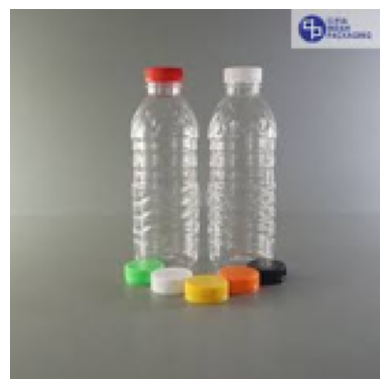

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediksi Subkelas: Plastik
Kategori Utama: Anorganik


('Plastik', 'Anorganik')

In [16]:
# Uji prediksi dengan gambar
uploaded = files.upload()
image_path = list(uploaded.keys())[0] # Ganti dengan path gambar uji

img = Image.open(image_path).convert("RGB")
img = img.resize((150, 150))  # sesuai input model

plt.imshow(img)
plt.axis("off")
plt.show()

predict_image(image_path, model, class_names, kategori_mapping)

# Evaluasi dan Visualisasi

In [15]:
# Evaluasi di valid set
validation_loss, validation_acc = model.evaluate(validation_generator)
print(f'\n🎯 Akurasi valid: {validation_acc:.2%}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.8842 - loss: 0.4382

🎯 Akurasi Test: 88.31%


In [16]:
# Evaluasi di train set
train_loss, train_acc = model.evaluate(train_generator)
print(f'\n🎯 Akurasi train: {train_acc:.2%}')

180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 186ms/step - accuracy: 1.0000 - loss: 0.0017

🎯 Akurasi train: 100.00%


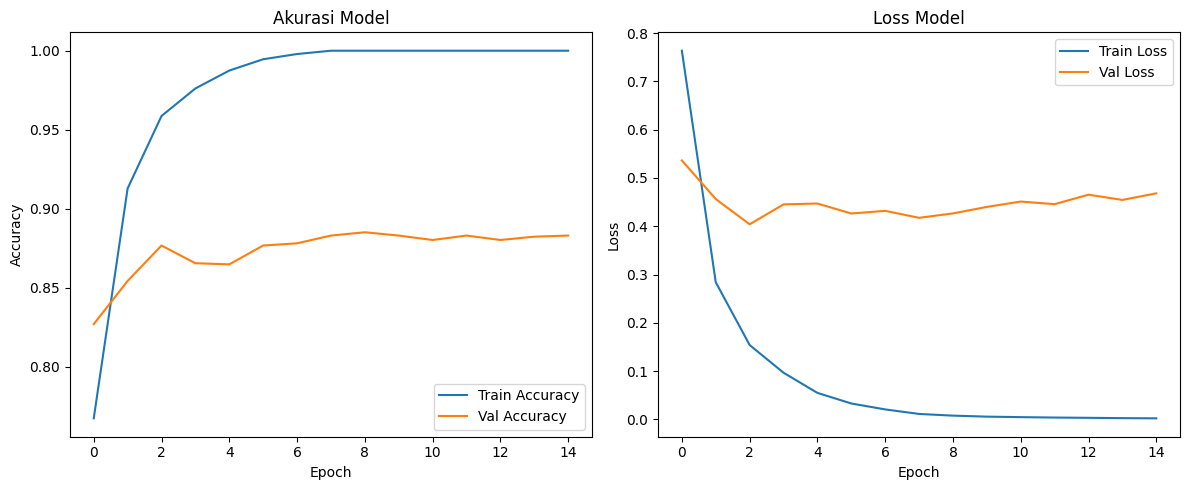

In [17]:
import matplotlib.pyplot as plt

# Ambil nilai dari objek history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# SIMPAN MODEL

In [18]:
from tensorflow.keras.models import load_model

model.save("model_sampah.h5")

In [19]:
from google.colab import files
files.download("model_sampah.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# 1. Export ke SavedModel (buat TF-Lite/TFJS)
model.export('saved_model/intel-image-classification')

# 2. Convert ke TF-Lite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/intel-image-classification')
tflite_model = converter.convert()

with open('intel-image-classification.tflite', 'wb') as f:
    f.write(tflite_model)

# 3. Convert ke TensorFlowJS
!pip install tensorflowjs
import tensorflowjs as tfjs

tfjs.converters.convert_tf_saved_model('saved_model/intel-image-classification', 'tfjs_model')

print("\nSemua format model berhasil disimpan!")

Saved artifact at 'saved_model/intel-image-classification'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  140499166936912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499165785616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499165785424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499167118544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499165783696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499165787728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499165788112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499165788496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499165788304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140499165786768: TensorSpec(shape=(), dtype=tf.resource, n


Semua format model berhasil disimpan!


In [21]:

folder_path = '/content/tfjs_model'

zip_path = '/content/tfjs_model.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

print("Berhasil dikompres menjadi:", zip_path)

Berhasil dikompres menjadi: /content/tfjs_model.zip


In [22]:

folder_path = '/content/saved_model'

zip_path = '/content/saved_model.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

print("Berhasil dikompres menjadi:", zip_path)

Berhasil dikompres menjadi: /content/saved_model.zip
